In [44]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping

<function matplotlib.pyplot.show(close=None, block=None)>

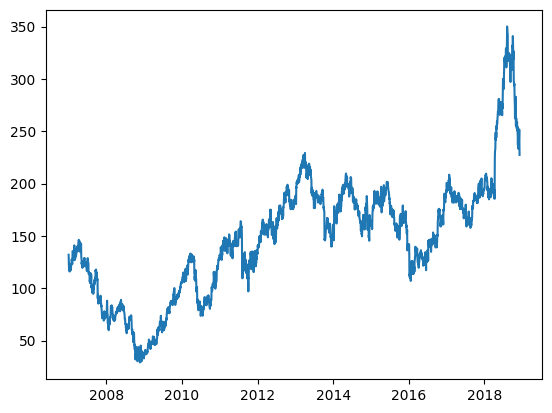

In [3]:
df=pd.read_csv('003.csv',index_col='Date',parse_dates=True)
plt.plot(df.Close)
plt.show

In [4]:
X, y = df.drop(columns=['Close']), df.Close.values
# X.shape, y.shape
X

,Open,High,Low,Adj Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2007-01-02,127.000000,133.000000,127.000000,76.526367,420128,0.0,0.0
2007-01-03,131.500000,133.000000,127.250000,73.772598,517141,0.0,0.0
2007-01-04,125.000000,127.000000,121.750000,70.873871,679753,0.0,0.0
2007-01-05,118.000000,121.250000,115.000000,69.859299,1503804,0.0,0.0
2007-01-08,121.500000,124.500000,121.500000,71.743469,547970,0.0,0.0
...,...,...,...,...,...,...,...
2018-11-30,245.600006,245.600006,238.600006,196.626358,510342,0.0,0.0
2018-12-03,245.899994,255.600006,245.800003,206.036270,346959,0.0,0.0
2018-12-04,252.100006,254.899994,248.199997,203.990646,411592,0.0,0.0


In [5]:
from sklearn.decomposition import PCA
X, y = df.drop(columns=['Close']), df.Close.values
# Create a PCA instance with 1 component
X_pca=X[['Open','High','Low','Adj Close']]

pca = PCA(n_components=1)

# Fit the PCA model to your data and transform the data
pca_result = pca.fit_transform(X_pca)

# Create a new DataFrame with the PCA result
pca_df = pd.DataFrame(data=pca_result, columns=['PCA_Score'])

X['PCA_Score'] = np.array(pca_df['PCA_Score'])

# Drop the original columns
X.drop(['Open','High','Low','Adj Close'], axis=1, inplace=True)

X

,Volume,Dividends,Stock Splits,PCA_Score
Date,,,,
2007-01-02,420128,0.0,0.0,-40.518263
2007-01-03,517141,0.0,0.0,-39.277622
2007-01-04,679753,0.0,0.0,-49.882945
2007-01-05,1503804,0.0,0.0,-60.426381
2007-01-08,547970,0.0,0.0,-52.744499
...,...,...,...,...
2018-11-30,510342,0.0,0.0,190.092241
2018-12-03,346959,0.0,0.0,203.328887
2018-12-04,411592,0.0,0.0,206.501367


In [6]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

mm=MinMaxScaler()
ss = StandardScaler()
X_trans = ss.fit_transform(X)
y_trans = mm.fit_transform(y.reshape(-1, 1))

X_trans

array([[-0.47444927, -0.05938888,  0.        , -0.36570105],
       [-0.30786179, -0.05938888,  0.        , -0.35450355],
       [-0.02862991, -0.05938888,  0.        , -0.45022279],
       ...,
       [-0.489107  , -0.05938888,  0.        ,  1.86379579],
       [-0.73760847, -0.05938888,  0.        ,  1.69238571],
       [-0.39965121, -0.05938888,  0.        ,  1.53258968]])

In [13]:
def split_sequences(input_sequences, output_sequence, n_steps_in, n_steps_out):
    X, y = list(), list() # instantiate X and y
    for i in range(len(input_sequences)):
        # find the end of the input, output sequence
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out - 1
        # check if we are beyond the dataset
        if out_end_ix > len(input_sequences):
            break
        # gather input and output of the pattern
        seq_x, seq_y = input_sequences[i:end_ix], output_sequence[end_ix-1:out_end_ix,-1]
        X.append(seq_x), y.append(seq_y)
    return np.array(X), np.array(y)

in_steps=100
out_steps=1
X_ss, y_mm = split_sequences(X_trans, y_trans, in_steps, out_steps)
print(X_ss.shape, y_mm.shape)
print(y_mm)

(2901, 100, 4) (2901, 1)
[[0.28629283]
 [0.29485981]
 [0.30654205]
 ...
 [0.6859813 ]
 [0.65700933]
 [0.61775698]]


In [15]:
total_samples = len(X)

train_test_cutoff = round(0.96 * total_samples)

X_train = X_ss[:-(total_samples-train_test_cutoff-2)]
X_test = X_ss[-(total_samples-train_test_cutoff-2):]

y_train = y_mm[:-(total_samples-train_test_cutoff-2)]
y_test = y_mm[-(total_samples-train_test_cutoff-2):] 

print("Training Shape:", X_train.shape, y_train.shape)
print("Testing Shape:", X_test.shape, y_test.shape) 

Training Shape: (2783, 100, 4) (2783, 1)
Testing Shape: (118, 100, 4) (118, 1)


In [16]:
X_train_tensors = tf.convert_to_tensor(X_train)
X_test_tensors = tf.convert_to_tensor(X_test)
y_train_tensors = tf.convert_to_tensor(y_train)
y_test_tensors = tf.convert_to_tensor(y_test)

In [23]:
X_train_tensors_final = tf.reshape(X_train_tensors, shape=(-1, 100, X_train_tensors.shape[2]))
X_test_tensors_final = tf.reshape(X_test_tensors, shape=(-1, 100, X_test_tensors.shape[2]))


print("Training Shape:", X_train_tensors_final.shape, y_train_tensors.shape)
print("Testing Shape:", X_test_tensors_final.shape, y_test_tensors.shape) 
print(type(X_test_tensors_final))

Training Shape: (2783, 100, 4) (2783, 1)
Testing Shape: (118, 100, 4) (118, 1)
<class 'tensorflow.python.framework.ops.EagerTensor'>


Splitting the data into train and Validation sets


In [31]:
test_size = 0.1
random_state = 123

#Converting to numpy arrays for sklearn train_test_split
X_train_tensors_final=np.array(X_train_tensors_final)
y_train_tensors=np.array(y_train_tensors)

#Splitting the data set
X_train_tn, X_val_tn, y_train_tn, y_val_tn = train_test_split(
    X_train_tensors_final, y_train_tensors, test_size=test_size, random_state=random_state
)

#Converting the numpy arrays back to tensorflow tensors
X_train_tn = tf.convert_to_tensor(X_train_tn)
y_train_tn = tf.convert_to_tensor(y_train_tn)
X_val_tn=tf.convert_to_tensor(X_val_tn)
y_val_tn=tf.convert_to_tensor(y_val_tn)

print(type(X_train_tn),X_train_tn.shape)
print(type(X_val_tn),X_val_tn.shape)
print(type(y_val_tn),y_val_tn.shape)
print(type(y_train_tn),y_train_tn.shape)

<class 'tensorflow.python.framework.ops.EagerTensor'> (2504, 100, 4)
<class 'tensorflow.python.framework.ops.EagerTensor'> (279, 100, 4)
<class 'tensorflow.python.framework.ops.EagerTensor'> (279, 1)
<class 'tensorflow.python.framework.ops.EagerTensor'> (2504, 1)


In [102]:

class StackedLSTM(tf.keras.Model):
    def __init__(self, num_classes, input_size, hidden_size, num_layers,fc_neurons):
        super().__init__()

        # Initialize the LSTM layers
        lstm_layers = []
        for i in range(num_layers):
            lstm_layer = tf.keras.layers.LSTM(units=hidden_size, return_sequences=True)
            lstm_layers.append(lstm_layer)
            
        # Add the LSTM layers to the model
        self.model = tf.keras.Sequential(lstm_layers)

        # Add the fully connected layers to the model
        self.fc_1 = tf.keras.layers.Dense(fc_neurons, activation='relu')
        self.fc_2 = tf.keras.layers.Dense(num_classes)

    def call(self, x):
        # Forward pass through the model
        x = self.model(x)
        hn = tf.reshape(x, [-1, self.hidden_size])
        out = self.fc_1(hn)
        out = self.fc_2(out)

        return out


In [103]:
def training_loop(n_epochs, model, optimizer, loss_fn, X_train, y_train,X_val,y_val, X_test, y_test,pat):
    for epoch in range(n_epochs):
        # Compile the model

        early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=pat)

        model.compile(optimizer=optimizer, loss=loss_fn)
        dropout = tf.keras.layers.Dropout(0.2)
        # Train the model
        model.fit(X_train, y_train, epochs=n_epochs,validation_data=(X_val,y_val),callbacks=[early_stopping])
        #Evaluate the model on train set
        train_loss=model.evaluate(X_train_tn,y_train_tn)

        #Evaluate the model on validation set
        Validation_loss=(model.evaluate(X_val_tn,y_val_tn))

        # Evaluate the model on the test set
        test_loss = model.evaluate(X_test, y_test)

        if epoch % 10 == 0:
            print("Epoch: %d, train loss: %1.5f, Validation loss: %1.5f, test loss: %1.5f" % (epoch,train_loss.item(), Validation_loss.item(), test_loss.item()))

In [104]:
import warnings
warnings.filterwarnings('ignore')

n_epochs = 500 # 1000 epochs
learning_rate = 0.01 # 0.001 lr
input_sizes = 4 # number of features
hidden_size = 100 # number of features in hidden state
num_layers = 1 # number of stacked lstm layers
pat=3 #Patience for early stopping
num_classes = 1 # number of output classes 
fc_neurons=128
lstm=StackedLSTM(num_classes,input_sizes,hidden_size,num_layers,fc_neurons)
lossses=tf.keras.losses.MeanSquaredError


In [105]:
training_loop(n_epochs,lstm,'adam',lossses,X_train_tn,y_train_tn,X_val_tn,y_val_tn,X_test_tensors_final,y_test_tensors,10)

Epoch 1/500


AttributeError: in user code:

    File "c:\Users\risha\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py", line 1377, in train_function  *
        return step_function(self, iterator)
    File "c:\Users\risha\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py", line 1360, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\risha\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py", line 1349, in run_step  **
        outputs = model.train_step(data)
    File "c:\Users\risha\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py", line 1126, in train_step
        y_pred = self(x, training=True)
    File "c:\Users\risha\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\risha\AppData\Local\Temp\__autograph_generated_fileibuu44bq.py", line 11, in tf__call
        hn = ag__.converted_call(ag__.ld(tf).reshape, (ag__.ld(x), [-1, ag__.ld(self).hidden_size]), None, fscope)

    AttributeError: Exception encountered when calling layer 'stacked_lstm_19' (type StackedLSTM).
    
    in user code:
    
        File "C:\Users\risha\AppData\Local\Temp\ipykernel_16648\21203351.py", line 21, in call  *
            hn = tf.reshape(x, [-1, self.hidden_size])
    
        AttributeError: 'StackedLSTM' object has no attribute 'hidden_size'
    
    
    Call arguments received by layer 'stacked_lstm_19' (type StackedLSTM):
      • x=tf.Tensor(shape=(None, 100, 4), dtype=float32)
